In [1]:
# imports
import sys
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import CoClustering
from surprise.model_selection import train_test_split, KFold

In [2]:
# constants and initialization
dataset = 'ml' # folder of dataset: anime, ml, lfm
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'item'
top_fraction = 0.2
folds = 5
user_events_cats_file = dataset + '/user_events_cats.txt'
low_user_file = dataset + '/low_main_users.txt'
medium_user_file = dataset + '/medium_main_users.txt'
high_user_file = dataset + '/high_main_users.txt'

save_metrics = False

cats_file = dataset + '/categories.txt'

In [3]:
cols_cats = ['user', 'item', 'preference', 'cats']
df_events_cats = pd.read_csv(user_events_cats_file, sep=',').dropna()
df_events_cats.columns = cols_cats
df_events_cats['cats'] = df_events_cats['cats'].astype(str)
df_events_cats

,user,item,preference,cats
0,5,2987,4,3|0|16
1,40,2987,5,3|0|16
2,53,2987,5,3|0|16
3,62,2987,4,3|0|16
4,92,2987,4,3|0|16
...,...,...,...,...
675605,5494,3530,4,2
675606,5717,2258,4,7
675607,5949,2198,5,12
675608,526,1062,3,6


In [4]:
df_events_cats = df_events_cats[df_events_cats['preference'] >= item_threshold]
print('No. filtered user events: ' + str(len(df_events_cats)))
print('No. filtered items: ' + str(len(df_events_cats[predict_col].unique())))
print('No. filtered users: ' + str(len(df_events_cats['user'].unique())))

No. filtered user events: 675610
No. filtered items: 3667
No. filtered users: 3000


In [5]:
# get user distribution
user_dist = df_events_cats['user'].value_counts()
num_users = len(user_dist)
print('Mean items per user: ' + str(user_dist.mean()))
print('Min items per user: ' + str(user_dist.min()))
print('Max items per user: ' + str(user_dist.max()))

Mean items per user: 225.20333333333335
Min items per user: 50
Max items per user: 1850


In [6]:
# get item distribution
item_dist = df_events_cats[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 3667


In [7]:
item_dist

2858    1886
1196    1860
260     1801
1210    1702
589     1635
        ... 
2226       1
3762       1
1134       1
2821       1
3517       1
Name: item, Length: 3667, dtype: int64

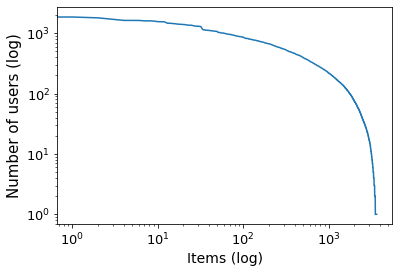

In [8]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Items (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of users (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')

In [9]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 733


In [10]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


Text(0.5, 1.0, 'ML')

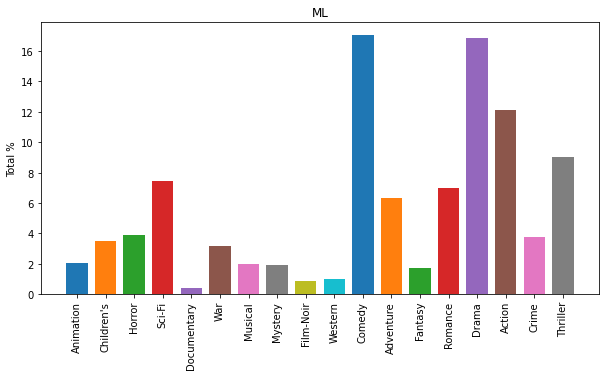

In [11]:
df_cats = pd.read_csv(cats_file, sep=',')
df_cats.columns = ['name', 'cats']

df_cat_dist = df_events_cats.copy()
df_cat_dist.drop(['item', 'preference'], axis=1, inplace=True)
df_cat_dist["cats"] = df_cat_dist["cats"].str.split("|")
df_cat_dist = df_cat_dist.explode("cats").reset_index(drop=True)
df_cat_dist = df_cat_dist.groupby('cats').count().reset_index()#.set_index('cats')

df_cat_dist['cats'] = df_cat_dist['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
df_cat_dist = df_cat_dist.merge(df_cats, on='cats')
df_cat_dist.set_index('cats', inplace=True)
df_cat_dist.columns = ['count', 'category']
df_cat_dist['count'] /= (df_cat_dist['count'].sum() / 100)
df_cat_dist_T = df_cat_dist.set_index('category').T
height = df_cat_dist['count'].to_list()
x = [x for x in range(len(df_cat_dist_T.columns))]

plt.figure(figsize=(10,5))
for i in range(len(x)):
    plt.bar(x=x[i], height=height[i], width=.75, label=df_cat_dist_T.columns[i])

plt.ylabel("Total %")
plt.xticks([x for x in range(len(df_cat_dist_T.columns))], labels=df_cat_dist_T.columns, rotation=90)
plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
# plt.savefig(dataset + '/genres.png', dpi=300, bbox_inches='tight')

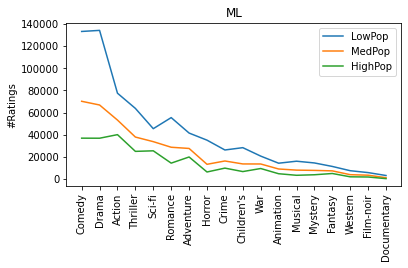

736672
418863
255437


In [12]:
# Get dataset
df_item_pop = df_events_cats.copy()
# Remove unnecessary columns
df_item_pop.drop(['item', 'preference'], axis=1, inplace=True)
# Split cat column and count their occurrence
df_item_pop["cats"] = df_item_pop["cats"].str.split("|")
df_item_pop = df_item_pop.explode("cats").reset_index(drop=True)

df_item_pop_cats = df_item_pop.groupby('cats').count().reset_index()
df_item_pop_cats.columns = ['cats', 'Total']
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_item_pop_group = df_item_pop.loc[df_item_pop['user'].isin([low_users, medium_users, high_users][i].index)]
    df_item_pop_cats[groups[i]] = df_item_pop_group.groupby('cats').count().reset_index()['user']

# Make sure column types are the same (needed for merge)
df_item_pop_cats['cats'] = df_item_pop_cats['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
# Merge to get category names (str)
df_item_pop_cats = df_item_pop_cats.merge(df_cats, on='cats')
# Set cats column as index
df_item_pop_cats.set_index('cats', inplace=True)
df_item_pop_cats = df_item_pop_cats.sort_values('Total',ignore_index=True, ascending=False)

if dataset == 'anime':
    df_item_pop_cats = df_item_pop_cats.drop(range(20, 36)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(21, 28)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(7, 8)).reset_index(drop=True)
df_item_pop_cats.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_item_pop_cats['name'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("#Ratings")
plt.xlabel("")
plt.savefig(dataset+'/'+dataset+'_item_pop.pdf', dpi=300, bbox_inches='tight')
plt.show()

for i in range(len(groups)):
    print(df_item_pop_cats[groups[i]].sum())

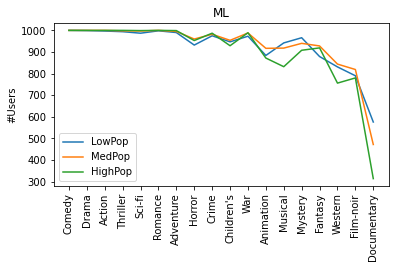

In [13]:
# Get dataset
df_item_pop = df_events_cats.copy()
# Remove unnecessary columns
df_item_pop.drop(['item', 'preference'], axis=1, inplace=True)
# Split cat column and count their occurrence
df_item_pop["cats"] = df_item_pop["cats"].str.split("|")
df_item_pop = df_item_pop.explode("cats").reset_index(drop=True)

df_item_pop_cats = df_item_pop.groupby('cats').count().reset_index()
df_item_pop_cats.columns = ['cats', 'Total']
groups = ['LowPop', 'MedPop', 'HighPop']

sum_col = 'Sum'
df_item_pop_cats[sum_col] = 0
for i in range(len(groups)):
    df_item_pop_group = df_item_pop.loc[df_item_pop['user'].isin([low_users, medium_users, high_users][i].index)]
    df_item_pop_group = df_item_pop_group.drop_duplicates(subset=['user', 'cats'])
    df_item_pop_cats[groups[i]] = df_item_pop_group.groupby('cats').count().reset_index()['user']

# Make sure column types are the same (needed for merge)
df_item_pop_cats['cats'] = df_item_pop_cats['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
# Merge to get category names (str)
df_item_pop_cats = df_item_pop_cats.merge(df_cats, on='cats')
# Set cats column as index
df_item_pop_cats.set_index('cats', inplace=True)

df_item_pop_cats = df_item_pop_cats.sort_values('Total',ignore_index=True, ascending=False)

if dataset == 'anime':
    df_item_pop_cats = df_item_pop_cats.drop(range(20, 36)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(21, 28)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(7, 8)).reset_index(drop=True)
df_item_pop_cats.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_item_pop_cats['name'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("#Users")
plt.xlabel("")
plt.savefig(dataset+'/'+dataset+'_user_genres.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
df_gap_p = pd.DataFrame(columns=['user', 'gap_p'])
df_gap_p_items = pd.DataFrame(columns=['user', 'item', 'gap_p'])
for u, df in df_events_cats.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    df_gap_p = pd.concat([df_gap_p, pd.DataFrame.from_dict({'user': [u], 'gap_p': [user_pop_item_fraq]})], ignore_index=True)

    item_list = list(df[predict_col])
    df_gap_p_items = pd.concat([df_gap_p_items, pd.DataFrame.from_dict({'user': [u for _ in item_list], 'item': item_list, 'gap_p': [user_pop_item_fraq for _ in item_list]})], ignore_index=True)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


In [15]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 369.729
Average MedMS profile size: 194.374
Average HighMS profile size: 111.507


## Recommendations using Surprise package


In [16]:
#df_events = scaled_df_events
print('Min rating: ' + str(df_events_cats['preference'].min()))
print('Max rating: ' + str(df_events_cats['preference'].max()))

Min rating: 1
Max rating: 5


In [17]:
reader = Reader(rating_scale=(df_events_cats['preference'].min(), df_events_cats['preference'].max()))

In [18]:
data = Dataset.load_from_df(df_events_cats[df_events_cats.columns[:-1]], reader)
kf = KFold(n_splits=folds, random_state=my_seed)

In [19]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [20]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n

In [21]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [22]:
def get_mae_of_groups(predictions):
    low_predictions = []
    med_predictions = []
    high_predictions = []
    dict_maes = {'user': [], 'item': [], 'mae': []}
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        dict_maes['user'].append(uid)
        dict_maes['item'].append(iid)
        dict_maes['mae'].append(accuracy.mae(prediction, verbose=False))

        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in high_users.index:
            high_predictions.append(accuracy.mae(prediction, verbose=False))

    return pd.DataFrame.from_dict(dict_maes), [low_predictions, med_predictions, high_predictions]

In [23]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users

In [24]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [BaselineOnly(),
         KNNBasic(sim_options=sim_users),
         KNNWithMeans(sim_options=sim_users),
         NMF(n_factors=30, random_state=my_seed),
         CoClustering(n_cltr_u=3, n_cltr_i=3, random_state=my_seed)]
algo_names = ['UserItemAvg',
              'UserKNN',
              'UserKNNAvg',
              'NMF',
              'Co-Custering']

In [25]:
q = [{} for _ in range(folds)]
maes = {}
maes_user = {}
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []
gaps_q = {}
for i in range(0, len(algo_names)):
    print(algo_names[i])

    df_item_dist[algo_names[i]] = 0
    low_rec_gaps = [0 for _ in range(folds)]
    medium_rec_gaps = [0 for _ in range(folds)]
    high_rec_gaps = [0 for _ in range(folds)]

    fold = 0
    mae_list = []
    predictions_maes = [0 for _ in range(3)]
    for trainset, testset in kf.split(data):
        # get accuracy for personalized approaches
        algos[i].fit(trainset)
        predictions = algos[i].test(testset, verbose=False)
        mae_list.append(accuracy.mae(predictions, verbose=False))
        df_mae, predictions_mae = get_mae_of_groups(predictions)
        if algo_names[i] not in maes:
            maes[algo_names[i]] = df_mae
            maes[algo_names[i]]['mae'] /= folds
        else:
            maes[algo_names[i]]['mae'] += df_mae['mae'] / folds

        predictions_maes = [predictions_maes[i] + np.mean(predictions_mae[i])/folds for i in range(3)]
        print(stats.ttest_ind(predictions_mae[0], predictions_mae[1]))
        print(stats.ttest_ind(predictions_mae[0], predictions_mae[2]))

        top_n = get_top_n(predictions, n=10)
        q[fold][algo_names[i]] = top_n.items()

        low_count = 0
        med_count = 0
        high_count = 0
        dict_gap_q = {'user':[], 'gap_q':[]}
        for uid, user_ratings in top_n.items():
            iid_list = []
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
                iid_list.append(iid)
            gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
            dict_gap_q['user'].append(uid)
            dict_gap_q['gap_q'].append(gap / folds)
            if uid in low_users.index:
                low_rec_gaps[fold] += gap
                low_count += 1
            elif uid in medium_users.index:
                medium_rec_gaps[fold] += gap
                med_count += 1
            elif uid in high_users.index:
                high_rec_gaps[fold] += gap
                high_count += 1

        if algo_names[i] not in gaps_q:
            gaps_q[algo_names[i]] = pd.DataFrame.from_dict(dict_gap_q)
        else:
            gaps_q[algo_names[i]]['gap_q'] += pd.DataFrame.from_dict(dict_gap_q)['gap_q']
        low_rec_gaps[fold] /= low_count
        medium_rec_gaps[fold] /= med_count
        high_rec_gaps[fold] /= high_count
        # check, if all users are used
        print(low_count, med_count, high_count)
        fold += 1

    low_rec_gap_list.append(np.mean(low_rec_gaps))
    medium_rec_gap_list.append(np.mean(medium_rec_gaps))
    high_rec_gap_list.append(np.mean(high_rec_gaps))

    maes_user[algo_names[i]] = maes[algo_names[i]].drop(['item'], axis=1)

    print(np.mean(mae_list))
    print('LowMS: ' + str(predictions_maes[0]))
    print('MedMS: ' + str(predictions_maes[1]))
    print('HighMS: ' + str(predictions_maes[2]))

    i += 1 # next algorithm

UserItemAvg
Estimating biases using als...
Ttest_indResult(statistic=9.29831750718438, pvalue=1.4512285208499107e-20)
Ttest_indResult(statistic=10.397772090310957, pvalue=2.617664244072576e-25)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=6.698082688364753, pvalue=2.121575244746611e-11)
Ttest_indResult(statistic=9.58144618748186, pvalue=9.786038353860444e-22)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=7.268559144882001, pvalue=3.6567910838813915e-13)
Ttest_indResult(statistic=11.261306555591945, pvalue=2.1255054622300312e-29)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=7.121772640341094, pvalue=1.0718145331508528e-12)
Ttest_indResult(statistic=12.694256325915129, pvalue=6.811825020755431e-37)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=7.741992078136949, pvalue=9.867819378402004e-15)
Ttest_indResult(statistic=11.751535395151874, pvalue=7.291137207123429e-32)
1000 1000 1000
0.

<ipython-input-25-fefcdad731cd>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Ttest_indResult(statistic=10.7339337021499, pvalue=7.266947923047532e-27)
Ttest_indResult(statistic=11.485467102279951, pvalue=1.634159093098136e-30)
1000 1000 1000
Ttest_indResult(statistic=9.390502947654397, pvalue=6.0775622421068486e-21)
Ttest_indResult(statistic=11.06195511054986, pvalue=1.9960492944482498e-28)
1000 1000 1000
Ttest_indResult(statistic=9.140166512921743, pvalue=6.335035163072358e-20)
Ttest_indResult(statistic=12.62593368449125, pvalue=1.624334782377103e-36)
1000 1000 1000
Ttest_indResult(statistic=9.385692742755644, pvalue=6.361406889839511e-21)
Ttest_indResult(statistic=14.199744701170298, pvalue=1.022679662329626e-45)
1000 1000 1000
Ttest_indResult(statistic=9.577833228327819, pvalue=1.0100521049235177e-21)
Ttest_indResult(statistic=13.06867353817003, pvalue=5.3674545800910735e-39)
1000 1000 1000
0.7193499444489544
LowMS: 0.7382782203903349
MedMS: 0.7038129420342206
HighMS: 0.6836782024518914


In [26]:
d_predictions = [{} for _ in range(folds)]
for fold in range(folds):
    for i in range(len(algo_names)):
        df_a = pd.DataFrame(q[fold][algo_names[i]], columns=['user', 'item_ratings'])
        df_a = df_a.explode('item_ratings')
        df_a[['item', 'rank']] = pd.DataFrame(df_a['item_ratings'].tolist(), index=df_a.index)
        df_a.drop('item_ratings', axis=1, inplace=True)
        df_a.sort_values('rank', ascending=False, inplace=True)
        d_predictions[fold][algo_names[i]] = df_a

d_predictions[0][algo_names[2]].head()

,user,item,rank
2289,2849,1256,5.0
2951,3686,2858,5.0
201,641,2858,5.0
2108,4694,527,5.0
2673,4584,926,5.0


In [27]:
low_pl_vals = []
medium_pl_vals = []
high_pl_vals = []
pls = {}
pls_items = {}
for i in range(0, len(algos)):
    print(algo_names[i])
    pl_low = (low_rec_gap_list[i] - low_gap) / low_gap
    pl_med = (medium_rec_gap_list[i] - medium_gap) / medium_gap
    pl_high = (high_rec_gap_list[i] - high_gap) / high_gap
    print('LowMS:', pl_low)
    print('MedMS:', pl_med)
    print('HighMS:', pl_high)

    low_pl_vals.append(pl_low)# * 100)
    medium_pl_vals.append(pl_med)# * 100)
    high_pl_vals.append(pl_high)# * 100)

    df_gap = gaps_q[algo_names[i]].merge(df_gap_p, on=['user'])
    df_gap['pl'] = (df_gap['gap_q'] - df_gap['gap_p']) / df_gap['gap_p']
    pls[algo_names[i]] = df_gap[['user', 'pl']]

    df_gap_items = df_gap_p_items.merge(gaps_q[algo_names[i]], on=['user'])
    df_gap_items['pl'] = (df_gap_items['gap_q'] - df_gap_items['gap_p']) / df_gap_items['gap_p']
    pls_items[algo_names[i]] = df_gap_items[['user', 'item', 'pl']]

    print(stats.ttest_ind(df_gap_items.loc[df_gap_items['user'].isin(low_users.index)]['pl'], df_gap_items.loc[df_gap_items['user'].isin(medium_users.index)]['pl']))
    print(stats.ttest_ind(df_gap_items.loc[df_gap_items['user'].isin(low_users.index)]['pl'], df_gap_items.loc[df_gap_items['user'].isin(high_users.index)]['pl']))
    print('----------------------')


UserItemAvg
LowMS: 0.6988866998201457
MedMS: 0.4224149636701501
HighMS: 0.23612119843055765
Ttest_indResult(statistic=610.202128038781, pvalue=0.0)
Ttest_indResult(statistic=767.2059207558862, pvalue=0.0)
----------------------
UserKNN
LowMS: 0.6361591082323125
MedMS: 0.37106718010998047
HighMS: 0.2043742566000665
Ttest_indResult(statistic=611.8317267486126, pvalue=0.0)
Ttest_indResult(statistic=765.5338672444813, pvalue=0.0)
----------------------
UserKNNAvg
LowMS: 0.49586870731332927
MedMS: 0.325882509451388
HighMS: 0.19719664980018206
Ttest_indResult(statistic=572.6218806195865, pvalue=0.0)
Ttest_indResult(statistic=713.780772429572, pvalue=0.0)
----------------------
NMF
LowMS: 0.5730612631709731
MedMS: 0.3711527213896702
HighMS: 0.21922572928198789
Ttest_indResult(statistic=577.4278045888457, pvalue=0.0)
Ttest_indResult(statistic=735.792543589074, pvalue=0.0)
----------------------
Co-Custering
LowMS: 0.719835875670895
MedMS: 0.4343410191544008
HighMS: 0.24235617225851486
Ttest_in

## Miscalibration Metric

In [28]:
def calc_pcu(df_events_):
    cols_pcu = ['user', 'cat', 'metric']
    df_events = df_events_.copy()

    cols_weights = ['user', 'sum']
    s_weights_sum = df_events.groupby('user')['preference'].sum().reset_index()
    s_weights_sum.columns = cols_weights

    df_events["cats"] = df_events["cats"].str.split("|")
    df_events_split = df_events.explode("cats").reset_index(drop=True)
    df_events_split["count"] = df_events_split.groupby(['user','item'])["cats"].transform('count')

    df_events_split["wipci"] = df_events_split["preference"] / df_events_split["count"]

    df_dist = df_events_split.groupby(['user', 'cats'])['wipci'].sum().to_frame().reset_index()

    df_msc = df_dist.merge(s_weights_sum, on=['user'])
    df_msc[['wipci']] = df_msc[['wipci']].div(df_msc['sum'], axis=0)
    df_msc.drop('sum', axis=1, inplace=True)
    df_msc.columns = cols_pcu
    return df_msc

In [29]:
df_pcu = calc_pcu(df_events_cats)
df_pcu.head()

,user,cat,metric
0,1,0,0.125601
1,1,1,0.133108
2,1,11,0.020270
3,1,13,0.018769
4,1,14,0.112087


In [30]:
def calc_qcu(df_predictions_, df_item_cats_, algo_name):
    # drop rows in ignore list
    # group by user id and artist
    df_predictions = df_predictions_.copy()
    df_item_cats = df_item_cats_.copy()
    df_predictions['user'] = df_predictions['user'].astype(int)
    df_predictions['item'] = df_predictions['item'].astype(int)
    df_item_cats['cats'] = df_item_cats['cats'].astype(str)

    df_predictions['rank'] = df_predictions['rank'].astype(float)
    # calc mean if item is recommended multiple times
    df_predictions = df_predictions.groupby(['user', 'item'])['rank'].mean().reset_index(name='preference')
    # Calculate sum of weights
    s_weights_sum = df_predictions.groupby('user')['preference'].sum().reset_index()
    s_weights_sum.columns = cols_weights
    # Split user_predictions genres into rows
    df_predictions = df_predictions.merge(df_item_cats,on='item', how='left')#.reset_index()
    df_predictions['cats'] = df_predictions['cats'].astype(str)
    df_predictions["cats"] = df_predictions["cats"].str.split("|")
    df_predictions = df_predictions.explode("cats").reset_index(drop=True)
    df_predictions["count"] = df_predictions.groupby(['user','item'])["cats"].transform('count')
    # calculate weighted p(c|i)
    # wi * pci, wi -> preference(rank), pci -> 1/count
    df_predictions["wipci"] = df_predictions["preference"] / df_predictions["count"]
    # Sum up genres
    df_dist = df_predictions.groupby(['user', 'cats'])['wipci'].sum().to_frame().reset_index()
    # Divide by sum of weights
    df_dist = df_dist.merge(s_weights_sum, on=['user'])
    df_dist['wipci'] /= df_dist['sum']
    df_dist.drop('sum', axis=1, inplace=True)
    df_dist.columns = cols_msc
    df_dist = df_dist[df_dist.astype(str)['cat'] != 'nan']
    return df_dist

In [31]:
df_item_cats = df_events_cats.copy()
df_item_cats.drop(['user', 'preference'], axis=1, inplace=True)
df_item_cats.drop_duplicates(inplace=True)
df_item_cats

,item,cats
0,2987,3|0|16
1143,2333,6
1519,1175,2|11
1759,39,2|5
2649,288,7|9
...,...,...
675605,3530,2
675606,2258,7
675607,2198,12
675608,1062,6


In [32]:
df_qcu = [{} for _ in range(folds)]
cols_weights = ['user', 'sum']
cols_msc = ['user', 'cat', 'metric']
for fold in range(folds):
    for i in range(0, len(algo_names)):
        df_msc = calc_qcu(d_predictions[fold][algo_names[i]], df_item_cats, algo_names[i])
        df_qcu[fold][algo_names[i]] = df_msc

In [33]:
alpha = .01

# 𝛼 · 𝑝(𝑐|𝑢)
df_pcu_a = df_pcu.copy()
df_pcu_a.loc[:,'metric'] *= alpha
df_pcu_a['user']=df_pcu_a['user'].astype(int)
df_pcu_a['cat']=df_pcu_a['cat'].astype(int)

df_pcu_a

,user,cat,metric
0,1,0,0.001256
1,1,1,0.001331
2,1,11,0.000203
3,1,13,0.000188
4,1,14,0.001121
...,...,...,...
49604,6039,5,0.000930
49605,6039,6,0.001195
49606,6039,7,0.000208
49607,6039,8,0.000056


In [34]:
df_pcu_a.loc[df_pcu_a['user'] == 3]['metric'].sum()

0.01

In [35]:
def calc_MCkl(df_qcu_, df_pcu_a, df_pcu):
    cols_q_head = ['user', 'cat']

    # (1 − 𝛼) · 𝑞(𝑐|𝑢)
    df_qcu = df_qcu_.copy()
    df_qcu.loc[:,'metric'] *= (1 - alpha)
    df_qcu['user'] = df_qcu['user'].astype(int)
    df_qcu['cat'] = df_qcu['cat'].astype(int)

    # 𝑞˜(𝑐|𝑢) allmusic
    df_q_head = df_pcu_a.join(df_qcu.set_index(cols_q_head), on=cols_q_head, lsuffix='_left', rsuffix='_right').fillna(0)
    df_q_head['q_head'] = df_q_head['metric_left'] + df_q_head['metric_right']
    df_pcu['cat'] = df_pcu['cat'].astype(int)
    df_q_head = df_q_head.join(df_pcu.set_index(cols_q_head), on=cols_q_head)

    # calculate MC_kl allmusic
    df_q_head['mc'] = df_q_head['metric'] * np.log(df_q_head['metric']/ df_q_head['q_head'])

    l_cat_mc = []
    for group in [low_users, medium_users, high_users]:
        l_cat_mc.append(df_q_head.loc[df_q_head['user'].isin(group.index)].drop('user', axis=1).groupby('cat')['mc'].mean())

    df_MC_kl = df_q_head.groupby('user')['mc'].sum().reset_index()
    return df_MC_kl, l_cat_mc


In [36]:
cols_q_head = ['user', 'cat']
MC_kl_d = {}
MC_cat_d = {}
df_metrics = pd.DataFrame()
df_metrics_low = pd.DataFrame()
df_metrics_med = pd.DataFrame()
df_metrics_high = pd.DataFrame()
# for each algo (UserItem, KNN, ...)
for i in range(0, len(algo_names)):
    print(algo_names[i])
    print('--------------------------------------')

    l_cat_mcs = [0 for _ in range(3000)]
    MC_kl = None
    for fold in range(folds):
        df_mc, list_cat_mc = calc_MCkl(df_qcu[fold][algo_names[i]], df_pcu_a, df_pcu)
        if MC_kl is None:
            MC_kl = df_mc
            MC_kl['mc'] /= folds
        else:
            MC_kl['mc'] += df_mc['mc'] / folds
        l_cat_mcs = [l_cat_mcs[i] + list_cat_mc[i]/folds for i in range(len(list_cat_mc))]

    print(MC_kl.head())
    print('--------------------------------------')
    print('Avg Total', MC_kl['mc'].mean())
    print('Avg Low', MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'].mean())
    print('Avg Med', MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc'].mean())
    print('Avg High', MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc'].mean())
    print('95%', stats.t.interval(alpha=0.95, df=len(MC_kl['mc'].tolist())-1, loc=np.mean(MC_kl['mc'].tolist()), scale=stats.sem(MC_kl['mc'].tolist())))

    MC_kl_d[algo_names[i]] = MC_kl
    df_metrics[algo_names[i]] = MC_kl['mc']
    MC_cat_d[algo_names[i]] = l_cat_mcs

    df_metrics_low[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc']
    df_metrics_med[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc']
    df_metrics_high[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc']

    print(stats.ttest_ind(MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'], MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc']))
    print(stats.ttest_ind(MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'], MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc']))

    print('======================================\n')

UserItemAvg
--------------------------------------
   user        mc
0     1  0.494352
1     2  0.560943
2     3  0.602113
3     5  0.743092
4     6  0.297175
--------------------------------------
Avg Total 0.7073469144093875
Avg Low 0.773655619090513
Avg Med 0.7206196992347755
Avg High 0.6277654249028745
95% (0.6994983007965779, 0.7151955280221972)
Ttest_indResult(statistic=5.193028072235238, pvalue=2.2792896143238533e-07)
Ttest_indResult(statistic=15.062238649590917, pvalue=1.2100703172341829e-48)

UserKNN
--------------------------------------
   user        mc
0     1  0.520437
1     2  0.724561
2     3  0.607650
3     5  0.860604
4     6  0.294799
--------------------------------------
Avg Total 0.6815775790883639
Avg Low 0.7323472867843919
Avg Med 0.6933531911978786
Avg High 0.6190322592828186
95% (0.6745169084698026, 0.6886382497069241)
Ttest_indResult(statistic=4.268591315687255, pvalue=2.0591856588977714e-05)
Ttest_indResult(statistic=12.948924659242536, pvalue=6.948154118198

In [37]:
# Saves the calculated metrics for each algorithm
users = pd.concat([low_users, medium_users, high_users])
for i in range(len(algo_names)):
    if save_metrics:
        maes_user[algo_names[i]].loc[maes_user[algo_names[i]]['user'].isin(users.index)].groupby('user')['mae'].mean().reset_index().merge(pls[algo_names[i]].loc[pls[algo_names[i]]['user'].isin(users.index)], on='user').merge(MC_kl_d[algo_names[i]].loc[MC_kl_d[algo_names[i]]['user'].isin(users.index)], on='user').to_csv(  algo_names[i] + '.csv', sep=';')

## Genre miscalibration sorted by count

Only a few genres are responsible for the high miscalibration value of certain groups. This is due to user profiles having an unproportionate amount of pertaining to these genres. We therefore will also not see any or only a weak correlation with the popularity lift metric, as those (popular) genres may not be the same as the ones creating a high miscalibration.

In [38]:
# set algorithm for plots manually: useritem = 0, knn = 1, knnavg = 2, nmf = 3, cocluster = 4
selected_algorithm = 3

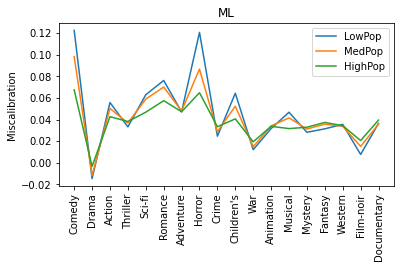

In [39]:
df_genre_mc_count = df_cat_dist.copy(deep=True)
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_genre_mc_count[groups[i]] = MC_cat_d[algo_names[selected_algorithm]][i].to_frame()['mc']
df_genre_mc_count = df_genre_mc_count.sort_values('count', ignore_index=True, ascending=False)
if dataset == 'anime':
    df_genre_mc_count = df_genre_mc_count.drop(range(20, 36)).reset_index(drop=True)
    df_genre_mc_count = df_genre_mc_count.drop(range(21, 28)).reset_index(drop=True)
    df_genre_mc_count = df_genre_mc_count.drop(range(7, 8)).reset_index(drop=True)
df_genre_mc_count.plot.line(y=groups, x='category', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_genre_mc_count['category'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
# if type == 'lfm':
plt.ylabel("Miscalibration")
plt.xlabel("")
plt.savefig(dataset + '/genre_mc_count_' + algo_names[selected_algorithm] + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Genre MAE sorted by count

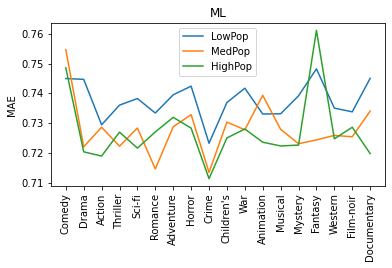

In [40]:
df_genre_mae_count = df_cat_dist.copy(deep=True)
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_mae_item = maes[algo_names[selected_algorithm]]
    df_mae_item = df_mae_item.loc[df_mae_item['user'].isin([low_users, medium_users, high_users][i].index)].drop(['user'], axis=1)
    df_mae_item['item'] = df_mae_item['item'].astype(int)
    df_mae_item = df_mae_item.merge(df_item_cats,on='item', how='left')
    df_mae_item["cats"] = df_mae_item["cats"].str.split("|")
    df_genre_mae_count[groups[i]] = df_mae_item.explode("cats").reset_index(drop=True).drop(['item'], axis=1).groupby('cats')['mae'].mean().reset_index()['mae']

df_genre_mae_count = df_genre_mae_count.sort_values('count', ignore_index=True, ascending=False)
if dataset == 'anime':
    df_genre_mae_count = df_genre_mae_count.drop(range(20, 36)).reset_index(drop=True)
    df_genre_mae_count = df_genre_mae_count.drop(range(21, 28)).reset_index(drop=True)
df_genre_mae_count.plot.line(y=groups, x='category', figsize=(6, 3))
labels = [label.capitalize() for label in list(df_genre_mae_count['category'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("MAE")
plt.xlabel("")
plt.savefig(dataset + '/genre_mae_count_' + algo_names[selected_algorithm] + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Genre popularity lift sorted by count

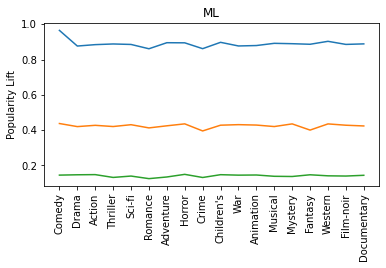

In [41]:
df_genre_pl_count = df_cat_dist.copy(deep=True)
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_pl_items = pls_items[algo_names[selected_algorithm]]
    df_pl_items = df_pl_items.loc[df_pl_items['user'].isin([low_users, medium_users, high_users][i].index)].drop(['user'], axis=1)
    df_pl_items['item'] = df_pl_items['item'].astype(int)
    df_pl_items = df_pl_items.merge(df_item_cats,on='item', how='left')
    df_pl_items["cats"] = df_pl_items["cats"].str.split("|")
    df_genre_pl_count[groups[i]]  = df_pl_items.explode("cats").reset_index(drop=True).drop(['item'], axis=1).groupby('cats')['pl'].mean().reset_index()['pl']

df_genre_pl_count = df_genre_pl_count.sort_values('count', ignore_index=True, ascending=False)
if dataset == 'anime':
    df_genre_pl_count = df_genre_pl_count.drop(range(20, 36)).reset_index(drop=True)
    df_genre_pl_count = df_genre_pl_count.drop(range(21, 28)).reset_index(drop=True)
    df_genre_pl_count = df_genre_pl_count.drop(range(7, 8)).reset_index(drop=True)
df_genre_pl_count.plot.line(y=groups, x='category', figsize=(6, 3), legend=False)
labels = [label.capitalize() for label in list(df_genre_pl_count['category'])]

plt.title({'anime':'MAL', 'ml':'ML', 'lfm':'LFM'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
# if type == 'lfm':
plt.ylabel("Popularity Lift")
plt.xlabel("")
plt.savefig(dataset + '/genre_pl_count_' + algo_names[selected_algorithm] + '.pdf', dpi=300, bbox_inches='tight')
plt.show()